In [ ]:
import numpy as np
import math
from math import pi
import torch
from matplotlib import pyplot as plt
from torch.distributions import MultivariateNormal

In [ ]:
torch.manual_seed(256)
torch.set_printoptions(precision=5, linewidth=140)

In [ ]:
n_clusters = 6
n_samples= 250

In [ ]:
centroids = torch.randn(n_clusters, 2) * 70 - 35

In [ ]:
def sample(c): return MultivariateNormal(c, torch.diag(torch.tensor([5., 5.]))).sample((n_samples,))

In [ ]:
data = torch.concat([sample(c) for c in centroids], axis=0)

In [ ]:
data.shape

torch.Size([1500, 2])

In [ ]:
def plot_data(centroids, data, ax=None):
    if ax is None: fig, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:, 0], samples[:, 1], s = 1)
        ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color="m", mew=3)

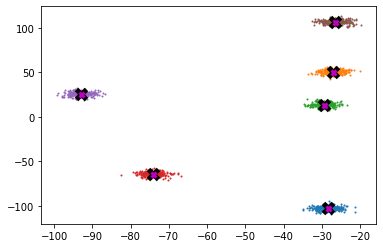

In [ ]:
plot_data(centroids, data)

In [ ]:
def gaussian(dist, bw=2.5): return (1/(math.sqrt(2*pi)*bw))*torch.exp(-0.5*(dist/bw)**2)

[<matplotlib.lines.Line2D>]

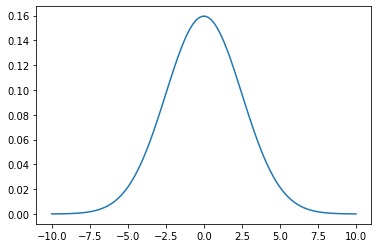

In [ ]:
fig, ax = plt.subplots()
x = torch.linspace(-10, 10, 100)
ax.plot(x, gaussian(x))

In [ ]:
def tri(dist, bw=10): return (-dist + bw).clamp(min=0)

[<matplotlib.lines.Line2D>]

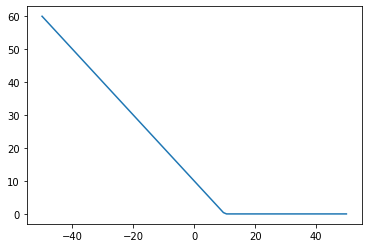

In [ ]:
fig, ax = plt.subplots()
x = torch.linspace(-50, 50, 100)
ax.plot(x, tri(x))

In [ ]:
X = data.clone()

In [ ]:
x = X[0]

In [ ]:
gaussian(((x - X)**2).sum(1).sqrt())

tensor([0.15958, 0.07880, 0.06436,  ..., 0.00000, 0.00000, 0.00000])

In [ ]:
def one_update(X, weight_func=gaussian):
    for i, x in enumerate(X):
        dist = ((x - X)**2).sum(1).sqrt()
        weight = weight_func(dist, bw=2.5)
        X[i] = (weight[..., None] * X).sum(0)/weight.sum(0)

In [ ]:
def meanshift(data, weight_func=gaussian):
    X = data.clone()
    for i in range(5): one_update(X, weight_func)
    return X

In [ ]:
X= meanshift(data)

In [ ]:
X

tensor([[ -28.42868, -102.61228],
        [ -28.42868, -102.61228],
        [ -28.42867, -102.61230],
        ...,
        [ -26.45944,  106.64550],
        [ -26.45944,  106.64550],
        [ -26.45944,  106.64550]])

In [ ]:
Y = meanshift(data)

In [ ]:
Y

tensor([[ -28.42868, -102.61228],
        [ -28.42868, -102.61228],
        [ -28.42867, -102.61230],
        ...,
        [ -26.45944,  106.64550],
        [ -26.45944,  106.64550],
        [ -26.45944,  106.64550]])

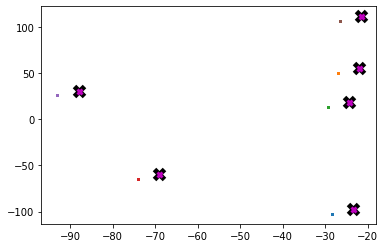

In [ ]:
plot_data(centroids+5, Y)

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def animate(d):
    if not d: return plot_data(centroids + 5, X, ax=ax)
    one_update(X)
    ax.clear()
    plot_data(centroids + 5, X, ax=ax)

In [ ]:
X= data.clone()
fig, ax = plt.subplots()
f = FuncAnimation(fig, animate, frames=5, interval=500, repeat=False)
plt.close()
HTML(f.to_jshtml())

## GPU Batched algorithm

In [ ]:
bs = 5
X = data.clone()
x = X[:bs]
x.shape, X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [ ]:
dist = ((x[:,None] - X[None]) ** 2).sum(-1).sqrt()
dist.shape, dist

(torch.Size([5, 1500]),
 tensor([[  0.00000,   2.96982,   3.36906,  ..., 209.04686, 210.20853, 209.90276],
         [  2.96982,   0.00000,   4.58362,  ..., 208.38335, 209.50293, 209.21017],
         [  3.36906,   4.58362,   0.00000,  ..., 212.35605, 213.50829, 213.20551],
         [  3.42341,   1.80829,   3.42423,  ..., 210.16139, 211.27600, 210.98482],
         [  2.33995,   1.62542,   2.96569,  ..., 209.84781, 210.97752, 210.68167]]))

In [ ]:
weight = gaussian(dist)
weight

tensor([[0.15958, 0.07880, 0.06436,  ..., 0.00000, 0.00000, 0.00000],
        [0.07880, 0.15958, 0.02972,  ..., 0.00000, 0.00000, 0.00000],
        [0.06436, 0.02972, 0.15958,  ..., 0.00000, 0.00000, 0.00000],
        [0.06249, 0.12285, 0.06246,  ..., 0.00000, 0.00000, 0.00000],
        [0.10298, 0.12917, 0.07896,  ..., 0.00000, 0.00000, 0.00000]])

In [ ]:
weight.shape

torch.Size([5, 1500])

In [ ]:
(weight @ X).shape

torch.Size([5, 2])

In [ ]:
weight.sum(1, keepdims=True).shape

torch.Size([5, 1])

In [ ]:
for i in range(0, 10, 2):
    print(i)

0
2
4
6
8


In [ ]:
def one_update(X, bs):
    n = len(X)
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        x = X[s]
        dist = ((x[:,None] - X[None]) ** 2).sum(-1).sqrt()
        weight = gaussian(dist)
        X[s] = (weight @ X)/ (weight.sum(1, keepdims=True))
        

In [ ]:
def meanshift(data, bs=16):
    X = data.clone()
    for i in range(10): one_update(X, bs)
    return X

In [ ]:
data = data.cuda()
%timeit X = meanshift(data, 32).cpu()

48.1 ms ± 543 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit X = meanshift(data, 500).cpu()

4.4 ms ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
X

tensor([[ -28.43384, -102.60363],
        [ -28.43384, -102.60363],
        [ -28.43384, -102.60363],
        ...,
        [ -26.46349,  106.65351],
        [ -26.46349,  106.65351],
        [ -26.46349,  106.65351]])

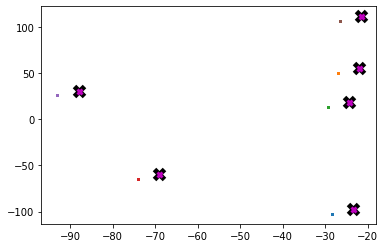

In [ ]:
plot_data(centroids +5, X)